<a href="https://colab.research.google.com/github/LIvanoff/moscow_clusters/blob/main/ds_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1285]:
num_apartment = []
num_obj = []
med_coverage_per = []
cluster = []
square = []

In [410]:
df = pd.read_excel('dataset.xlsx')

In [418]:
%%time
address = df['address'].to_numpy()

CPU times: user 4.8 ms, sys: 1 ms, total: 5.8 ms
Wall time: 5.74 ms


[1.0, 1.0, 1.0]


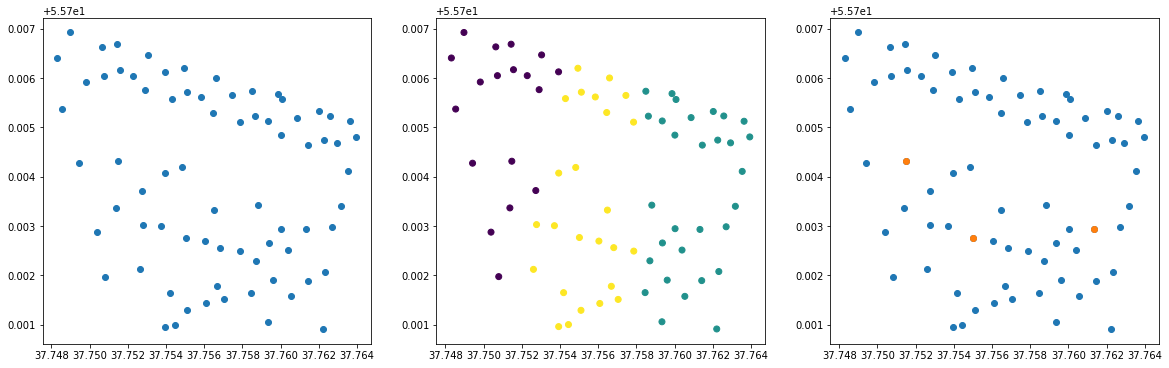

In [1358]:
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.cluster import KMeans
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from geopy.distance import great_circle as GC
import pandas as pd
import math



with open("./data (11).geojson", "r") as file_json:
    study_area = json.load(file_json)
    #print(json.dumps(study_area, indent=4))

coordinates = []
for i in study_area['features'][0]['geometry']['coordinates'][0]:
    coordinates.append(i)

coordinates.pop(-1)

latlong = []
latitude = df['latitude'].to_numpy()
longitude = df['longitude'].to_numpy()
residents = df['apartment'].to_numpy()
index_list = []
sum_residents = 0

for i in range(1,len(df)):
    point = Point(longitude[i], latitude[i])
    polygon = Polygon(coordinates)
    if polygon.contains(point) == True:
      latlong.append([longitude[i],latitude[i]])
      index_list.append(i)
      if df.loc[i,'type'] == 'Жилой дом':
        sum_residents += residents[i]



np_latlong = np.asarray(latlong)
X = np.vstack(np_latlong)

#n_clusters # было раньше int((sum_residents)/1500)
################################################################################
k_means = KMeans(n_clusters = 3)
################################################################################
moskva = k_means.fit_predict(X)

house_dict = {}

for i in range(0,k_means.n_clusters):
  house_dict[i] = []
  count = 0
  for j in range(0,len(moskva)):
    if moskva[j] == i:
      count +=1
  house_dict[i].append(count)

weights = []

for i in index_list:
  if df.loc[i,'type'] == 'Жилой дом':
    if 40 < df.loc[i,'apartment'] <= 80:
      weights.append(2)
    elif 80 < df.loc[i,'apartment'] <= 160:
      weights.append(3)
    elif df.loc[i,'apartment'] <= 40:
      weights.append(1)
    elif 160 < df.loc[i,'apartment'] <= 160:
      weights.append(3)
    elif df.loc[i,'apartment'] <= 40:
      weights.append(1)
    elif 160 < df.loc[i,'apartment'] <= 200:
      weights.append(4)
    if 200 < df.loc[i,'apartment']:
      weights.append(5)
  elif df.loc[i, 'type'] == 'Постамат':
    weights.append(7)
  elif df.loc[i,'type'] == 'киоск' or df.loc[i,'type'] == 'пресс-стенд':
    weights.append(10)
  elif df.loc[i, 'type'] == 'Спортивный объект':
    weights.append(6)
  elif df.loc[i, 'type'] == 'МФЦ' or df.loc[i, 'type'] == 'Флагманский офис':
    weights.append(8)

sum_weights = []
for i in range(0,k_means.n_clusters):
  sum = 0
  for j in range(0, len(index_list)):
    if moskva[j] == i:
      sum += weights[j]
  sum_weights.append(sum)

latitude_postamate = []
longitude_postamate = []
latitude_sum = 0
longitude_sum = 0

for i in range(0,k_means.n_clusters):
  for j in range(0, len(index_list)):
    if moskva[j] == i:
      latitude_sum += (weights[j]*latitude[index_list[j]])/sum_weights[i]
      longitude_sum += (weights[j]*longitude[index_list[j]])/sum_weights[i]
  latitude_postamate.append(latitude_sum)
  longitude_postamate.append(longitude_sum)
  latitude_sum = 0
  longitude_sum = 0


new_latlong = []
for i in range(0,len(longitude_postamate)):
  near_point = 1 # 1 km
  better_long = latitude_postamate[i]
  better_lat = longitude_postamate[i]
  for j in range(0,len(moskva)):
    if moskva[j] == i:
      a = (latitude_postamate[i], longitude_postamate[i])
      b = (latitude[index_list[j]], longitude[index_list[j]])
      if GC(a,b) < near_point:
        near_point = GC(a,b)
        better_lat = latitude[index_list[j]]
        better_long = longitude[index_list[j]]
  latitude_postamate[i] = better_lat
  longitude_postamate[i] = better_long
  new_latlong.append([longitude_postamate[i],latitude_postamate[i]])

ratings = []

######################  ЭТО ДЕЛАЛ ВЛАД #######################################
ratings = []
_dict = {}
for i in range(len(moskva)):
  _dict[str(moskva[i])] = []

for i in range(0,len(longitude_postamate)):
  for j in range(0,len(moskva)):
    if moskva[j] == i:
      _dict[str(moskva[j])].append(j)


for z in range(0,len(longitude_postamate)):
  rating = 0.0
  count = 0.0
  for i in range(len(_dict[str(z)])):
    x = latitude[index_list[_dict[str(z)][i]]] * 111
    y = longitude[index_list[_dict[str(z)][i]]] * 71

    x0 = latitude_postamate[z] * 111
    y0 = longitude_postamate[z] * 71

    R = 0.400
    
    if ((x - x0)**2 + (y - y0)**2 <= R**2):
      count += 1
  rating = count / len(_dict[str(z)])
  ratings.append(rating)
print(ratings)
##############################################################################
sum_rat = math.fsum(ratings)
sum_rat  /=len(ratings)


new_np_latlong = np.asarray(new_latlong)
new_X = np.vstack(new_np_latlong)

fig, axs = plt.subplots(1, 3, figsize=(20,6))
axs[0].scatter(X[:, 0], X[:, 1], marker='o')
axs[1].scatter(X[:, 0], X[:, 1], c=moskva)
axs[2].scatter(X[:,0],X[:,1], marker='o')
axs[2].scatter(new_X[:,0],new_X[:,1], marker='o')



In [987]:
residents[i]

'6\xa0'

In [1359]:
num_apartment.append(sum_residents)
num_obj.append(len(index_list))
med_coverage_per.append(sum_rat)
cluster.append(k_means.n_clusters)
square.append(polygon.area)

In [1360]:
sum_residents

9308

In [1361]:
print(num_apartment)
print(num_obj)
print(med_coverage_per)
print(cluster)
print(square)

[6676, 12367, 9898, 3242, 19005, 11518, 4301, 3468, 1231, 19455, 9308]
[25, 114, 48, 52, 95, 62, 42, 113, 42, 157, 73]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[3, 7, 5, 4, 8, 6, 2, 6, 2, 9, 3]
[7.226809150001364e-05, 0.0001352118580000111, 0.00010998526449998451, 5.4698484999988654e-05, 0.00015413807250007764, 0.00013801813499992872, 6.56896244999886e-05, 0.000125582751000034, 4.5578996000009854e-05, 0.00021004705650000052, 8.426683249996771e-05]


In [1362]:
data = {'number place': [],'apartments': [], 'square' : [], 'med coverage per' : [], 'clusters' :[]}
data_for_learning = pd.DataFrame(data)
data_for_learning['number place'] = num_obj
data_for_learning['apartments'] = num_apartment
data_for_learning['square'] = square
data_for_learning['med coverage per'] = med_coverage_per
data_for_learning['clusters'] = cluster
data_for_learning.to_excel('y_test3.xlsx') # data_05_01_36

#**ОБУЧЕНИЕ МОДЕЛИ**

---

In [ ]:
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score

In [1364]:
df_train = pd.read_excel('data_for_learning_v16.xlsx')
df_test = pd.read_excel('test4.xlsx')
num_place = df_test['number place']

In [579]:
df_test = pd.read_excel('test.xlsx')

In [1369]:
y_train = np.array(df_train['clusters'])
X_train = df_train[['number place','apartments','square']].to_numpy() # 


y_train = y_train.reshape(-1, 1)
X_test = df_test[['number place','apartments','square']].to_numpy() # 
X_test = X_test.reshape(43, 3)
y_test = np.array(df_test['clusters'])
y_test = y_test.reshape(-1, 1)

**Обучение с помощью линейной регресии**

In [1278]:
lin_regres = LinearRegression().fit(X_train, y_train)
y_pred_lin_regres = lin_regres.predict(X_test)

for i in range(len(y_pred_lin_regres )):
  print('Предсказание: '+str(y_pred_lin_regres [i])+' Реальность: '+str(y_test[i]))
  
print('Коэффициенты:', lin_regres.coef_)# Ожидаемое среднее значение y, когда все X = 0
print('Средняя квадратичная ошибка (MSE): %.2f'% mean_squared_error(lin_regres.predict(X_test), y_test))

Предсказание: [17.62352168] Реальность: [20]
Предсказание: [9.96710752] Реальность: [9]
Предсказание: [46.86686267] Реальность: [55]
Предсказание: [9.10839896] Реальность: [8]
Предсказание: [19.09304881] Реальность: [16]
Предсказание: [11.68183735] Реальность: [14]
Предсказание: [14.30899649] Реальность: [14]
Предсказание: [13.87420067] Реальность: [14]
Предсказание: [21.24205465] Реальность: [14]
Предсказание: [2.90382015] Реальность: [1]
Предсказание: [8.97049464] Реальность: [9]
Предсказание: [9.1561052] Реальность: [10]
Предсказание: [62.50916291] Реальность: [70]
Предсказание: [5.14092332] Реальность: [2]
Предсказание: [1.9940481] Реальность: [1]
Предсказание: [3.74154069] Реальность: [2]
Предсказание: [9.35834243] Реальность: [8]
Предсказание: [2.63367223] Реальность: [2]
Предсказание: [4.73845775] Реальность: [4]
Предсказание: [5.58371931] Реальность: [5]
Предсказание: [12.15410928] Реальность: [7]
Предсказание: [10.33158743] Реальность: [10]
Предсказание: [8.48426266] Реальност

**Линейная регрессия с регуляризацией**

In [1371]:
ridge = Ridge(alpha=100).fit(X_train, y_train)

In [1372]:

y_pred_ridge = ridge.predict(X_test)

for i in range(len(y_pred_ridge)):
  print('Предсказание: '+str(y_pred_ridge[i])+' Реальность: '+str(y_test[i]))
  
print('Коэффициенты:', ridge.coef_)# Ожидаемое среднее значение y, когда все X = 0
print('Средняя квадратичная ошибка (MSE): %.2f'% mean_squared_error(ridge.predict(X_test), y_test))

Предсказание: [18.15787949] Реальность: [20]
Предсказание: [9.92421957] Реальность: [9]
Предсказание: [46.85247197] Реальность: [55]
Предсказание: [9.19065534] Реальность: [8]
Предсказание: [19.47464288] Реальность: [16]
Предсказание: [11.93967273] Реальность: [14]
Предсказание: [14.41154485] Реальность: [14]
Предсказание: [14.01088329] Реальность: [14]
Предсказание: [21.87073773] Реальность: [14]
Предсказание: [2.68369991] Реальность: [1]
Предсказание: [9.21219288] Реальность: [9]
Предсказание: [9.14613919] Реальность: [10]
Предсказание: [63.95515502] Реальность: [70]
Предсказание: [5.04304062] Реальность: [2]
Предсказание: [1.73060805] Реальность: [1]
Предсказание: [3.57897346] Реальность: [2]
Предсказание: [9.54055994] Реальность: [8]
Предсказание: [2.39796556] Реальность: [2]
Предсказание: [4.65217831] Реальность: [4]
Предсказание: [5.51959491] Реальность: [5]
Предсказание: [12.16698113] Реальность: [7]
Предсказание: [10.54832588] Реальность: [10]
Предсказание: [8.56225445] Реально

In [ ]:
y_pred_ridge[1]

array([9.16886812])

In [ ]:
y_train

In [ ]:
X_train

In [ ]:
X_test

array([[2.0654000e+04, 2.8700000e+02, 6.2327265e-04]])

In [ ]:
X_test

array([[1.24460000e+04, 1.50000000e+02, 2.08493739e-04]])

(array([17., 10.,  3.,  0.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([ 1. ,  7.9, 14.8, 21.7, 28.6, 35.5, 42.4, 49.3, 56.2, 63.1, 70. ]),
 <a list of 10 Patch objects>)

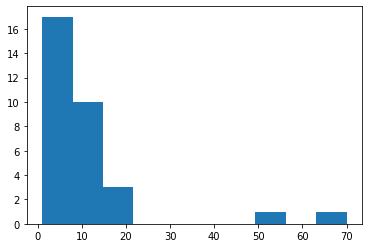

In [1110]:
plt.hist(y_test)

**Лассо**

In [1024]:
lasso = Lasso(alpha=1.0, max_iter=100).fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
print(y_pred_lasso)
print('Коэффициенты:', lasso.coef_)# Ожидаемое среднее значение y, когда все X = 0
print('Средняя квадратичная ошибка (MSE): %.2f'% mean_squared_error(lasso.predict(X_test), y_test))

[17.92872787  9.87556844 46.09164608  9.12885432 19.22479408 11.83656162
 11.83656162 14.3373762  13.89908895 21.57755539  2.74454716  9.08131073
  9.07827103 62.79027709  5.0752867   5.0752867   1.8008581   3.62931878
  9.44274744  2.44464574  4.6483878 ]
Коэффициенты: [0.03653784 0.00018629 0.        ]
Средняя квадратичная ошибка (MSE): 11.61


In [ ]:
# x = np.array([2.0 , 2.4, 1.5, 3.5, 3.5, 3.5, 3.5, 3.7, 3.7])
# y = np.array([196, 221, 136, 255, 244, 230, 232, 255, 267])

# lr = LinearRegression()
# lr.fit(x.reshape(-1, 1), y)

# print(lr.predict([[2.4]]))

In [ ]:
# plt.figure(figsize = (11,5))
# # 1 строка, 2 колонки, 1 график
# plt.subplot(1, 2, 1)
# plt.scatter(x = y_train, y = y_pred_train, c = "#7CAE00", alpha = 0.3)
# # Добавляем разделяющую поверхность (линию) на график
# z = np.polyfit(y_train, y_pred_train, 1)
# p = np.poly1d(z)
# plt.plot(y_test, p(y_test), "#F8766D")
# plt.ylabel('Предсказанный')
# plt.xlabel('Экспериментальный')
# # 1 строка, 2 колонки, 2 графика
# plt.subplot(1, 2, 2)
# plt.scatter(x = y_test, y = y_pred_test, c = "#619CFF", alpha = 0.3)
# z = np.polyfit(y_test, y_pred_test, 1)
# p = np.poly1d(z)
# plt.plot(y_test, p(y_test), "#F8766D")
# plt.xlabel('Экспериментальный LogS')
# plt.show()